# Interactome embedding analysis

----

In this notebook we analyze the different embeddings of the inferred U2OS interactome that was obtained by running the PCST algorithm on the confidence and hub-node pruned human PPI with the prizes set to the absolute log fold-change of the corresponding protein-coding genes when comparing their expression in U2OS cells to those in 1.4k other cancer cell lines and defining the edge costs by $1-|Spearman \ r|$. We have trained different embeddings using various GAE, Node2Vec models.

We will now compare the individual embedding solutions qualitatively and quantitatively by i.a. assessing the co-clustering of the genes in the respective embeddings. Additionally, we will cluster the individual embeddings and compare those with a clustering of GEX signatures of the CMAP data set that describe the change in GEX space upon over-expression with the different constructs.

Finally, we will also compare the co-clustering of those targets in the network as well as using image embeddings.
We thereby aim to show that the proximity in the interactome partially translates to proximity in the structural as well as the functional space.

---

## 0. Environmental setup

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import networkx as nx
import os
import sys
import random
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from node2vec import Node2Vec
from umap import UMAP
from tqdm import tqdm
import community

sys.path.append("../../..")

seed = 1234
np.random.seed(seed)
random.seed(seed)

%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
def plot_data(
    data,
    reduction="tsne",
    metric="euclidean",
    perplexity=30,
    normalize=False,
    labels=None,
    figsize=[12, 8],
    seed=1234,
    pcs=None,
):
    idx = data.index
    if normalize:
        data = StandardScaler().fit_transform(data)
    if pcs is not None:
        data = PCA(random_state=seed, n_components=pcs).fit_transform(data)
    if reduction == "tsne":
        embs = TSNE(
            random_state=seed,
            metric=metric,
            perplexity=perplexity,
            square_distances=True,
            n_components=2,
        ).fit_transform(data)
    elif reduction == "pca":
        embs = PCA(random_state=seed, n_components=2).fit_transform(data)
    elif reduction == "umap":
        embs = UMAP(random_state=seed).fit_transform(data)
    else:
        raise NotImplementedError()
    embs = pd.DataFrame(
        embs, columns=["{}_0".format(reduction), "{}_1".format(reduction)], index=idx
    )
    fig, ax = plt.subplots(figsize=figsize)
    if labels is None:
        ax = sns.scatterplot(
            data=embs, x="{}_0".format(reduction), y="{}_1".format(reduction)
        )
    else:
        embs["label"] = np.array(labels)
        ax = sns.scatterplot(
            data=embs,
            x="{}_0".format(reduction),
            y="{}_1".format(reduction),
            hue="label",
        )
    return fig, ax

<IPython.core.display.Javascript object>

In [3]:
def compare_dist_clustering(
    dist_df1,
    dist_df2,
    linkage1="average",
    linkage2="average",
    filter_nodes=None,
    metric="ari",
):
    dist_df1_duplicates = dist_df1.index.duplicated(keep="first")
    dist_df1 = dist_df1.loc[~dist_df1_duplicates, ~dist_df1_duplicates]

    dist_df2_duplicates = dist_df2.index.duplicated(keep="first")
    dist_df2 = dist_df2.loc[~dist_df2_duplicates, ~dist_df2_duplicates]
    node_set = set(dist_df1.index).intersection(set(dist_df2.index))
    if filter_nodes is not None:
        node_set = node_set.intersection(filter_nodes)

    dist_df1 = dist_df1.loc[node_set, node_set]
    dist_df2 = dist_df2.loc[node_set, node_set]
    ari = np.zeros([len(node_set), len(node_set)])
    for i in tqdm(range(len(node_set)), desc="Compute ARI"):
        cluster_sol1 = AgglomerativeClustering(
            affinity="precomputed", n_clusters=i + 1, linkage=linkage1
        ).fit_predict(dist_df1.loc[node_set, node_set])
        for j in range(len(node_set)):
            cluster_sol2 = AgglomerativeClustering(
                affinity="precomputed", n_clusters=j + 1, linkage=linkage2
            ).fit_predict(dist_df2.loc[node_set, node_set])
            if metric == "ari":
                ari[i, j] = adjusted_rand_score(cluster_sol1, cluster_sol2)
            elif metric == "ami":
                ari[i, j] = adjusted_mutual_info_score(cluster_sol1, cluster_sol2)
            else:
                raise NotImplementedError
    return ari

<IPython.core.display.Javascript object>

In [4]:
def plot_cocluster_metric(ari, title, sol_id1, sol_id2, vmin=0, vmax=1, figsize=[6, 4]):
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(ari, cmap="vlag", vmin=vmin, vmax=vmax, ax=ax)
    ax.set_title("{} (max: {})".format(title, np.round((ari).flatten()[1:-1].max(), 3)))
    ax.set_xlabel("n_clusters ({})".format(sol_id1))
    ax.set_ylabel("n_clusters ({})".format(sol_id2))
    plt.show()
    plt.close()

<IPython.core.display.Javascript object>

## 1. Read in data

### 1.1. Interactome embeddings

First, we will read in the different latent embeddings of the derived U2OS-specific interactome.

In [5]:
root_dir = "../../../data/experiments/ppi_embeddings/gae_103121/conf_hub_mis_ext_ppi/"

<IPython.core.display.Javascript object>

In [6]:
n2v_embs = pd.read_csv(
    root_dir + "n2v_conf_hub_mis_ext_ppi.csv",
    index_col=0,
)
n2v_embs.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
ATRX,0.332374,-0.017829,0.105278,-0.276670,0.204078,0.160766,-0.043017,0.005612,0.355588,0.116873,...,0.120104,0.017070,0.049720,-0.115399,0.245512,0.030116,0.011697,-0.175666,0.060236,0.216208
HSPA1B,-0.205084,-0.115479,0.015883,0.032246,0.282748,0.033780,-0.314221,-0.009368,0.251551,0.205258,...,0.137882,-0.201090,-0.106164,-0.249569,0.051176,0.024592,0.401747,-0.026147,-0.119166,-0.067923
CSDC2,0.064486,0.066444,-0.367109,-0.093139,-0.259868,0.026687,-0.009085,0.364485,-0.468099,0.055733,...,0.061810,-0.063130,0.083422,0.135344,0.058457,-0.061584,-0.024035,-0.248490,-0.063183,-0.152842
MYC,-1.318183,0.221971,0.827883,-0.072498,0.043275,0.137221,-0.477127,-0.547208,0.170698,0.081828,...,0.024590,0.032021,-0.338159,-0.949309,-0.001121,0.155618,-0.133025,0.076953,0.066221,0.092151
NDN,0.003832,-0.074224,0.146384,0.346253,-0.290357,-0.380354,-0.047637,0.025229,-0.313511,-0.135424,...,0.018888,0.297818,-0.220347,0.077493,0.208381,0.016489,0.108796,-0.095600,-0.057474,-0.068167


<IPython.core.display.Javascript object>

In [7]:
gae_embs = pd.read_csv(
    root_dir + "gae_conf_hub_mis_ext_ppi_wo_gex.csv",
    index_col=0,
)
gae_embs.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
ATRX,0.072353,-0.027258,-0.091908,0.187608,0.179181,-0.170925,-0.149142,0.144606,0.008158,-0.289278,...,-0.233857,-0.015314,-0.175149,0.045319,-0.042125,0.039650,0.224198,-0.161241,0.033389,-0.086075
HSPA1B,-0.223821,-0.015973,-0.250731,-0.146890,-0.045251,-0.311176,-0.000179,0.061820,-0.305480,0.218858,...,-0.097724,0.072277,0.084426,-0.122786,-0.012462,-0.236725,0.175607,0.178095,-0.058191,0.031205
CSDC2,0.014344,0.149678,-0.130477,-0.013773,0.048236,0.042227,0.159252,0.013028,-0.030890,0.095618,...,0.077964,-0.030643,-0.028603,0.067105,0.110244,-0.030080,0.021835,-0.040532,-0.008798,0.064496
MYC,-0.192147,-0.271671,0.319053,-0.049854,-0.021815,-0.322364,-0.045711,-0.234494,-0.256765,-0.540042,...,0.036706,0.385372,0.124437,-0.244985,-0.563091,0.014187,0.300378,0.136075,-0.141692,-0.379670
NDN,-0.018462,-0.043443,0.086470,0.066841,0.038214,-0.063834,0.024038,-0.088213,0.061784,-0.269793,...,0.130891,0.072224,0.036671,-0.019804,-0.164458,0.055203,0.059999,0.051237,-0.199620,-0.194469


<IPython.core.display.Javascript object>

In [8]:
gex_gae_embs = pd.read_csv(
    root_dir + "gae_conf_hub_mis_ext_ppi_w_scgex.csv",
    index_col=0,
)
gex_gae_embs.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
ATRX,0.134555,-0.125449,0.173306,0.287053,-0.076248,-0.110264,-0.054140,-0.126227,-0.070322,-0.002123,...,-0.123337,-0.064645,0.115971,-0.042166,0.002933,-0.001853,-0.321792,0.065063,-0.063841,0.304043
HSPA1B,0.035582,-0.036457,0.193669,-0.094247,0.217502,-0.214653,0.008034,-0.130397,-0.016810,0.033637,...,0.272458,-0.123811,-0.006596,-0.075003,-0.093695,0.070812,0.042085,0.229830,-0.253012,-0.141558
CSDC2,-0.033771,0.280435,0.060822,-0.033694,-0.182313,0.009267,0.020427,-0.238973,-0.146689,0.050699,...,0.125594,0.240329,-0.187593,0.044589,-0.141300,0.132475,0.022674,0.186472,0.002941,0.102894
MYC,0.121494,-0.286289,0.157862,-0.293001,-0.099543,-0.273404,-0.327894,-0.144363,0.243668,-0.225315,...,-0.315346,-0.055066,0.101240,-0.010103,-0.035436,-0.071856,0.080616,-0.131131,-0.243079,0.080311
NDN,0.175287,-0.017696,-0.090320,-0.241161,-0.140835,-0.301735,-0.036960,-0.082267,-0.136038,0.081129,...,0.043264,-0.110668,-0.013928,-0.043249,0.082272,0.010554,0.088753,-0.089792,-0.191665,-0.104936


<IPython.core.display.Javascript object>

In [9]:
spearman_gae_embs = pd.read_csv(
    root_dir + "gae_conf_hub_mis_ext_ppi_wo_gex_w_correlation.csv",
    index_col=0,
)
spearman_gae_embs.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
ATRX,-0.217369,0.010457,-0.161424,0.013006,-0.026934,0.119454,0.303865,0.150196,0.004850,-0.056184,...,0.204447,-0.008573,-0.225943,0.185627,-0.232421,-0.119669,-0.049967,0.018325,0.034225,0.031468
HSPA1B,-0.000813,0.300610,0.120131,-0.080576,-0.179038,0.164659,-0.123626,0.121315,0.079321,0.246209,...,-0.128692,0.226362,-0.083786,0.014171,0.076409,0.029893,0.002152,0.276963,-0.329201,-0.132736
CSDC2,0.097263,-0.043693,-0.028644,-0.087491,-0.031875,-0.076722,-0.029223,-0.030990,-0.013951,-0.064750,...,0.011106,-0.065282,0.001407,-0.140932,0.034560,-0.036518,0.167161,-0.061470,-0.027355,-0.082938
MYC,-0.022150,0.020106,0.036839,0.477584,0.139576,0.324611,-0.069793,0.199631,0.273975,-0.124841,...,0.031439,0.250924,-0.253490,0.399979,-0.169833,-0.035107,-0.317869,0.110133,0.103074,0.248220
NDN,-0.009890,-0.092025,-0.014733,0.108557,0.158513,0.034334,0.059780,-0.003304,0.053344,-0.081370,...,0.067081,0.015025,-0.089479,0.138049,-0.000882,-0.030620,-0.139373,-0.002585,0.156423,0.076755


<IPython.core.display.Javascript object>

In [10]:
spearman_gex_gae_embs = pd.read_csv(
    root_dir + "gae_conf_hub_mis_ext_ppi_w_scgex_w_correlation.csv",
    index_col=0,
)
spearman_gex_gae_embs.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
ATRX,0.219572,0.183920,0.348237,-0.172366,0.014912,0.067065,-0.031132,-0.206441,-0.220231,-0.008671,...,-0.099795,0.238099,0.127311,-0.001286,0.032723,0.222072,0.090015,-0.207569,-0.278278,-0.096252
HSPA1B,-0.052570,0.008562,0.120000,-0.225334,0.020744,0.063134,-0.059080,0.054783,0.130286,-0.235293,...,-0.138956,0.137147,-0.013780,-0.326306,0.105875,0.144428,0.025133,0.124357,-0.126395,-0.109874
CSDC2,0.305466,-0.160896,-0.048281,-0.005745,0.439519,0.033980,0.057247,0.107465,0.286606,-0.174209,...,0.368664,0.050532,0.066187,-0.214716,-0.074921,-0.391905,0.113940,0.308238,-0.227752,0.418820
MYC,-0.252161,0.211645,0.478773,-0.510209,0.137177,0.207645,-0.049540,0.083767,0.311379,0.181995,...,0.264413,-0.027165,-0.157133,-0.026134,0.095625,0.031551,-0.101025,0.213581,-0.281989,-0.347098
NDN,0.076151,0.100110,0.233755,0.040658,0.118003,0.079323,0.215636,-0.030818,0.430654,0.158541,...,-0.056110,-0.291558,-0.244200,-0.162444,0.030532,-0.240309,-0.035819,0.051332,0.005893,-0.178589


<IPython.core.display.Javascript object>

In [11]:
pbulk_gex_gae_embs = pd.read_csv(
    root_dir + "gae_conf_hub_mis_ext_ppi_w_pbgex.csv",
    index_col=0,
)
pbulk_gex_gae_embs.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
ATRX,0.060175,0.036637,0.058260,-0.026922,0.036327,0.092494,0.013461,-0.064581,0.029095,0.051154,...,-0.063601,0.046692,0.042985,0.035398,0.085238,0.071862,-0.071522,0.046333,-0.052760,0.070936
HSPA1B,0.111018,0.092302,0.123496,-0.042094,0.037044,0.152411,0.008167,-0.103301,0.078783,0.081383,...,-0.104216,0.100269,0.101389,0.073395,0.140955,0.120384,-0.111938,0.083478,-0.087398,0.150889
CSDC2,0.032229,-0.017046,-0.054635,0.100299,-0.004286,-0.050010,-0.127237,0.071374,-0.101348,-0.077097,...,0.016244,-0.022238,-0.035690,-0.021115,-0.090432,-0.072896,0.096024,-0.114895,0.138881,0.001668
MYC,0.306740,0.376237,0.365775,-0.094088,0.080633,0.421364,0.052921,-0.246738,0.333906,0.340176,...,-0.326513,0.413940,0.412237,0.303005,0.401298,0.344025,-0.413608,0.253423,-0.238301,0.477924
NDN,0.032299,0.052229,-0.053236,0.140076,0.124069,0.113223,-0.088389,0.007371,-0.145884,0.014066,...,-0.106923,-0.005460,-0.021684,-0.037307,-0.012774,0.078530,-0.016017,-0.123857,0.119226,0.028212


<IPython.core.display.Javascript object>

---

### 1.2. GEX signatures

Next, we will read in the GEX profiles from the CMAP data set that show the response of U2OS cells in the functional domain which is closely linked to the regulatory domain.

Since the respective data is only available in the processed form of level 3 and onwards, we will for now use the final level of processing. This provides gene signatures that describe the change in the respective overexpression condition to the respective control given by the moderated z-score for the different replicates. For more information please refer to the CMAP data documentation.

Althought the signatures span over 12k genes only 978 of those were actually measured. We thus focus on those in the remainder of our analysis. The data has already been preprocessed to filter out the experiments that correspond to an overexpression of any of the gene targets also covered in our expression study.

In [12]:
cmap_data = pd.read_csv(
    "/home/paysan_d/PycharmProjects/image2reg/data/gex/cmap/filtered_l5_data_u2os.csv",
    index_col=0,
)
cmap_data.head()

,CAMSAP2,PPP2R5A,CISD1,AKAP8,TMEM109,CHAC1,FOS,ORC1,AARS,MLLT11,...,SERPINE1,HLA-DMA,STK10,BLCAP,ASCC3,KDELR2,HIST2H2BE,MELK,SMARCA4,target
cid,,,,,,,,,,,,,,,,,,,,,
TA.OE005_U2OS_72H:BRDN0000464889:1,0.30090,0.31210,-0.15385,0.39090,0.53360,0.46430,1.13275,0.56370,-0.59440,0.29370,...,-0.15785,0.58080,-0.57865,0.04165,-1.00705,-0.65015,-0.10060,-0.77265,-0.22600,SMAD3
TA.OE005_U2OS_72H:BRDN0000459386:1,0.63525,0.61450,0.69230,-0.65215,-0.15565,0.45355,1.94680,-0.24965,1.02950,-1.17495,...,-0.46945,-0.18220,0.39760,2.23775,-0.46560,0.43435,0.79090,-0.32655,-2.16460,PIK3CA
TA.OE005_U2OS_72H:BRDN0000410175:1,-0.29245,0.36240,0.11330,-0.26385,0.48625,-0.78705,-0.90775,-0.34735,-0.14545,-0.58355,...,1.00105,0.10480,-0.13915,-0.02055,-0.33860,0.33100,-0.38375,5.86720,-0.62195,SGK3
TA.OE005_U2OS_72H:BRDN0000464950:1,-0.56500,1.14185,-0.28610,0.50840,0.27205,0.21970,-0.59960,0.44335,0.51885,0.23335,...,-1.20675,2.18695,-1.06025,-0.01255,0.51865,-0.43130,-0.54085,0.21715,-1.36070,TSC1
TA.OE005_U2OS_72H:BRDN0000411728:1,-0.94355,0.09785,0.19735,-0.34985,-0.55525,-0.53205,0.56505,-0.51840,0.56295,-0.68630,...,0.80700,0.55225,-0.04225,0.05315,0.21825,0.56270,-1.04495,0.97745,-0.66255,IKBKE


<IPython.core.display.Javascript object>

---

### 1.3. Image embeddings

Next, we will also load the derived image embeddings into memory. To obtain a signature for each individual gene target, we will compute the median profiles in the latent space for all samples corresponding to a specific target.

In [13]:
val_latents = pd.read_hdf(
    "../../../data/experiments/image_embeddings/specific_targets/resnet_ensemble_centercrops_newtargets/val_latents.h5",
    index_col=0,
)
test_latents = pd.read_hdf(
    "../../../data/experiments/image_embeddings/specific_targets/resnet_ensemble_centercrops_newtargets/test_latents.h5",
    index_col=0,
)

label_dict = {
    "AKT1S1": 0,
    "ATF2": 1,
    "ATF4": 2,
    "BAX": 3,
    "BCL2L11": 4,
    "BRAF": 5,
    "CASP8": 6,
    "CDC42": 7,
    "CDKN1A": 8,
    "CEBPA": 9,
    "CREB1": 10,
    "CXXC4": 11,
    "DIABLO": 12,
    "E2F1": 13,
    "EIF4EBP1": 14,
    "ELK1": 15,
    "ERG": 16,
    "HRAS": 17,
    "IKBKB": 18,
    "IRAK4": 19,
    "JUN": 20,
    "MAP2K3": 21,
    "MAP3K2": 22,
    "MAP3K5": 23,
    "MAP3K9": 24,
    "MAPK7": 25,
    "MKNK1": 26,
    "MYD88": 27,
    "PKIA": 28,
    "PRKACA": 29,
    "PRKCE": 30,
    "RAF1": 31,
    "RELB": 32,
    "RHOA": 33,
    "SDHA": 34,
    "SMAD4": 35,
    "SRC": 36,
    "SREBF1": 37,
    "STK3": 38,
    "TSC2": 39,
    "WWTR1": 40,
}
label_dict = {v: k for k, v in label_dict.items()}
img_embs = val_latents.append(test_latents)
img_embs.iloc[:, -1] = img_embs.iloc[:, -1].map(label_dict)
# img_embs.index = img_embs.iloc[:, -1]
# img_embs = img_embs.iloc[:, :-1]
img_embs.head()

,zs_0,zs_1,zs_2,zs_3,zs_4,zs_5,zs_6,zs_7,zs_8,zs_9,...,zs_1015,zs_1016,zs_1017,zs_1018,zs_1019,zs_1020,zs_1021,zs_1022,zs_1023,labels
taoe005-u2os-72h-cp-a-au00044858_b22_s1_w148331f61-da0a-4ae2-87dd-e9794b581278_illum_corrected_1.tif,-0.472558,-0.142654,-0.237510,0.091395,-0.406682,0.089360,-0.170427,0.013201,-0.223532,-0.058161,...,-0.053438,-0.239088,-0.104232,-0.148728,-0.167135,-0.306409,0.316654,0.025254,-0.067055,PRKCE
taoe005-u2os-72h-cp-a-au00044858_b22_s1_w148331f61-da0a-4ae2-87dd-e9794b581278_illum_corrected_2.tif,-0.394429,-0.000635,-0.196612,0.027898,-0.415718,-0.138166,-0.196240,0.150511,-0.308347,-0.196658,...,-0.043220,-0.144102,-0.009910,0.014957,-0.173607,-0.289740,0.227134,0.090240,-0.231906,PRKCE
taoe005-u2os-72h-cp-a-au00044858_b22_s1_w148331f61-da0a-4ae2-87dd-e9794b581278_illum_corrected_3.tif,-0.416851,-0.152609,-0.074147,0.121526,-0.483779,-0.039233,-0.449306,0.005403,-0.126328,-0.230391,...,-0.010846,-0.200356,-0.023823,0.118798,-0.067732,-0.533435,0.204702,0.178948,-0.235677,PRKCE
taoe005-u2os-72h-cp-a-au00044858_b22_s1_w148331f61-da0a-4ae2-87dd-e9794b581278_illum_corrected_5.tif,-0.426256,-0.135591,-0.355323,-0.020830,-0.378492,0.073175,-0.303020,0.213291,-0.135486,-0.009195,...,0.289620,-0.180015,0.147437,0.100490,-0.163651,-0.475871,0.270310,0.383410,-0.110799,PRKCE
taoe005-u2os-72h-cp-a-au00044858_b22_s1_w148331f61-da0a-4ae2-87dd-e9794b581278_illum_corrected_6.tif,-0.337257,-0.137471,-0.211147,0.025161,-0.341839,0.072964,-0.297752,0.069341,-0.297291,-0.072254,...,0.128884,-0.097957,0.039748,0.062941,-0.044597,-0.422617,0.183750,0.194599,-0.184246,PRKCE


<IPython.core.display.Javascript object>

In [14]:
img_embs = img_embs.groupby(by="labels").median()
img_embs.head()

,zs_0,zs_1,zs_2,zs_3,zs_4,zs_5,zs_6,zs_7,zs_8,zs_9,...,zs_1014,zs_1015,zs_1016,zs_1017,zs_1018,zs_1019,zs_1020,zs_1021,zs_1022,zs_1023
labels,,,,,,,,,,,,,,,,,,,,,
AKT1S1,-0.158887,-0.055898,0.144482,0.130885,-0.315434,-0.013626,-0.113572,0.164594,-0.107034,-0.285694,...,-0.093594,-0.039398,0.088440,-0.129102,-0.133979,-0.158449,-0.251812,-0.106762,0.260074,-0.178452
ATF2,-0.201461,-0.124493,0.054950,0.064655,-0.324583,0.006854,-0.057711,0.201682,-0.034719,-0.325452,...,-0.063889,-0.041457,0.123038,-0.086203,-0.074060,-0.146555,-0.148935,-0.036950,0.165860,-0.096340
ATF4,-0.192773,-0.072780,0.057751,0.066180,-0.405336,0.003314,-0.133449,0.170480,-0.066075,-0.377675,...,-0.107932,-0.085404,0.100025,-0.045093,-0.129845,-0.196527,-0.175652,-0.033410,0.199830,-0.153523
BAX,-0.175017,-0.103844,0.012256,0.050834,-0.379194,0.025656,-0.101255,0.236295,-0.032681,-0.331568,...,-0.096035,-0.116030,0.058667,-0.093871,-0.101820,-0.187562,-0.161031,-0.015365,0.129411,-0.126922
BCL2L11,-0.276830,-0.075073,0.037767,0.096447,-0.354839,-0.012347,-0.232959,0.153218,-0.216397,-0.320472,...,-0.071319,-0.035706,0.036822,-0.130871,-0.114648,-0.049183,-0.219190,-0.062309,0.203175,-0.168711


<IPython.core.display.Javascript object>

---

### 1.4. Additional metadata

Finally, we will read in some more information regarding our ORF targets including their involvement in important pathways and whether or not they showed a specific structural phenotype upon overexpression.

In [15]:
spec_screen_data = pd.read_csv(
    "../../../data/other/specificity_screen_results.csv", index_col=0
)
spec_screen_data.head()
orf_targets = set(spec_screen_data.index)
spec_targets = set(spec_screen_data.loc[spec_screen_data["selected"]].index)

<IPython.core.display.Javascript object>

---
___

## 2. Comparison of the interactome embeddings

To assess the similarity and the differences between the different interactome embeddings, we will perform a simple co-cluster analyses. To this end, we will hierarchically cluster the computed latent spaces using average-linkage and the euclidean norm as a distance measure. Next, we will compute the similarity of the derived clusters for a varying number of clusters ranging from 1 to 754 clusters, i.e. from one large cluster spanning all nodes (genes) to the solution that consists of 754 singletons. 

To assess the similarity of the clusters formed in either of the spaces, we will look at the adjusted RandIndex.

As a first step, we will compute the euclidean distance matrices for each of the 754 nodes in the four different GAE as well as in the Node2Vec embedding.

In [16]:
n2v_dist = pd.DataFrame(
    squareform(pdist(n2v_embs, metric="euclidean")),
    columns=list(n2v_embs.index),
    index=list(n2v_embs.index),
)

<IPython.core.display.Javascript object>

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/seaborn/matrix.py:619: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


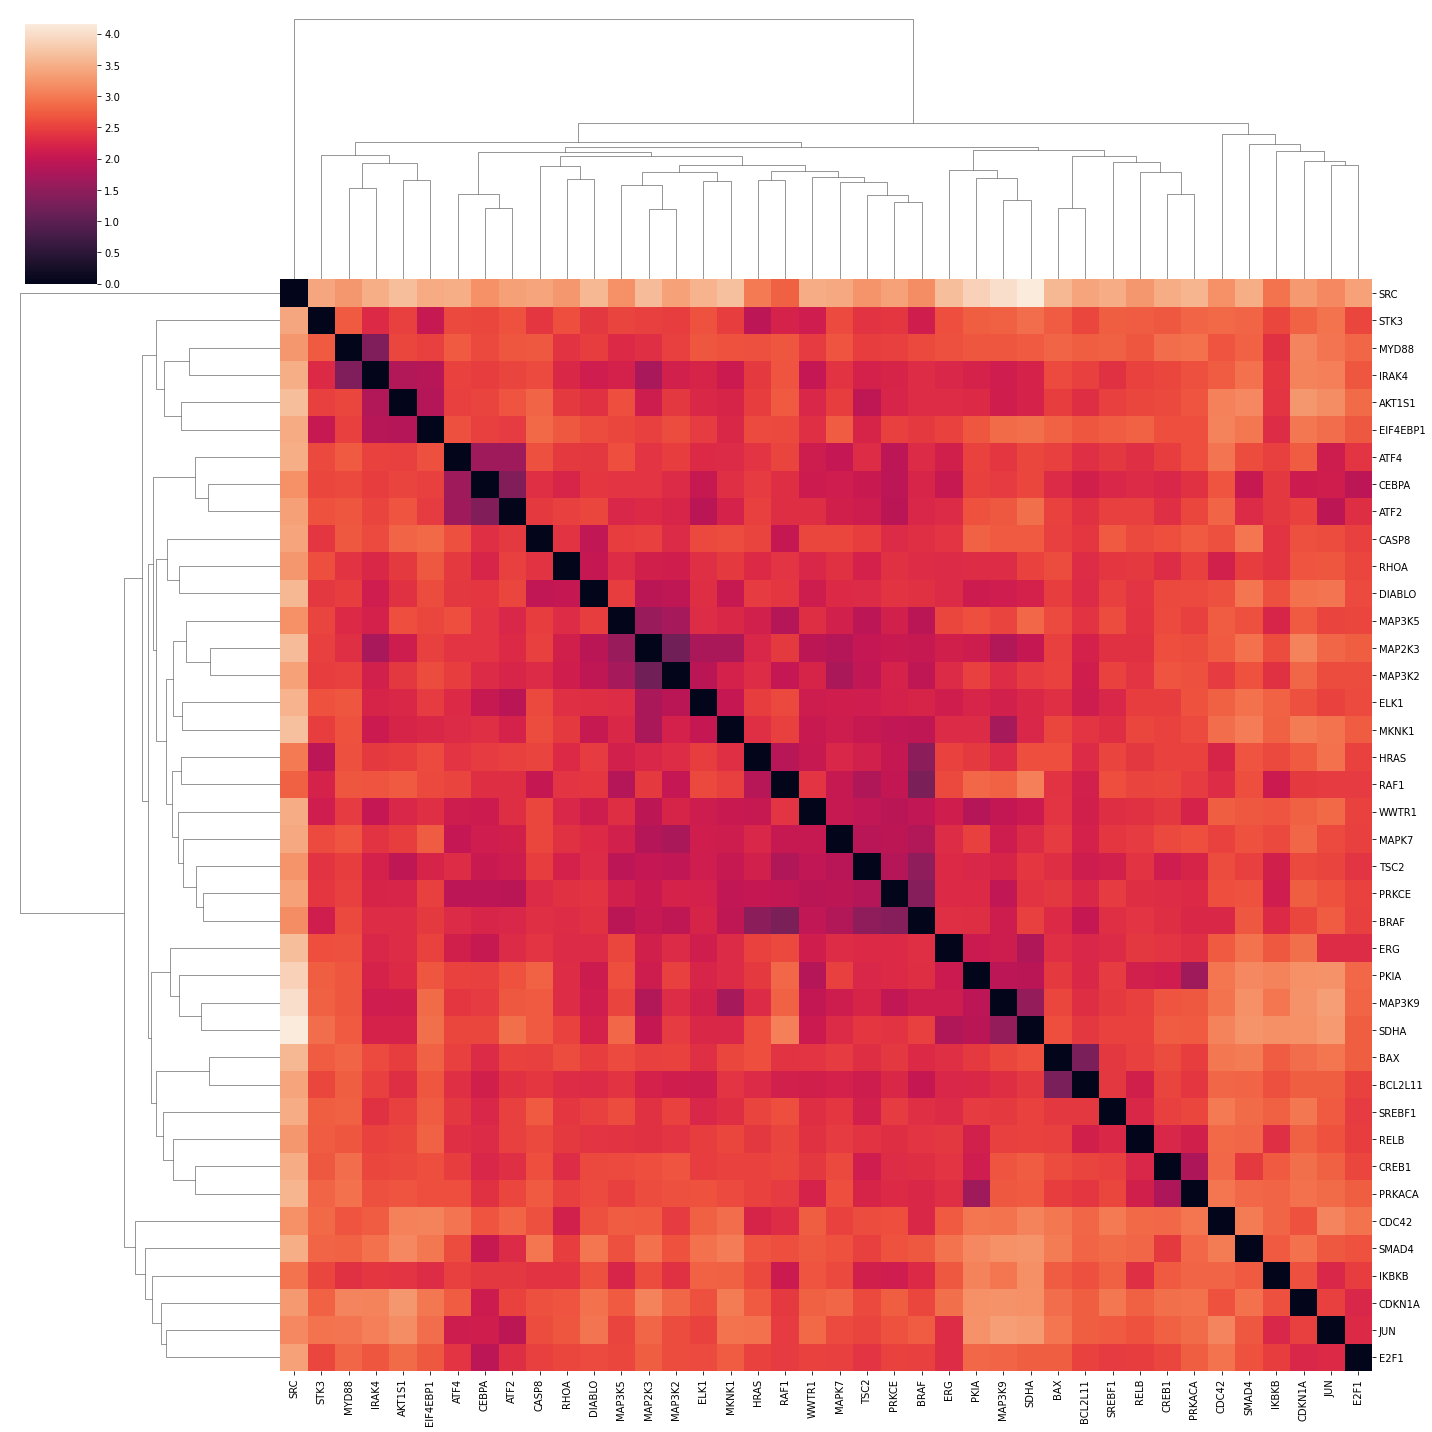

<IPython.core.display.Javascript object>

In [17]:
sns.clustermap(
    n2v_dist.loc[
        spec_targets.intersection(set(n2v_embs.index)),
        spec_targets.intersection(set(n2v_embs.index)),
    ],
    figsize=[20, 20],
)

In [18]:
gae_dist = pd.DataFrame(
    squareform(pdist(gae_embs, metric="euclidean")),
    columns=list(gae_embs.index),
    index=list(gae_embs.index),
)

<IPython.core.display.Javascript object>

In [19]:
gex_gae_dist = pd.DataFrame(
    squareform(pdist(gex_gae_embs, metric="euclidean")),
    columns=list(gex_gae_embs.index),
    index=list(gex_gae_embs.index),
)

<IPython.core.display.Javascript object>

In [20]:
pbulk_gex_gae_dist = pd.DataFrame(
    squareform(pdist(pbulk_gex_gae_embs, metric="euclidean")),
    columns=list(pbulk_gex_gae_embs.index),
    index=list(pbulk_gex_gae_embs.index),
)

<IPython.core.display.Javascript object>

In [21]:
spearman_gae_dist = pd.DataFrame(
    squareform(pdist(spearman_gae_embs, metric="euclidean")),
    columns=list(spearman_gae_embs.index),
    index=list(spearman_gae_embs.index),
)

<IPython.core.display.Javascript object>

In [22]:
spearman_gex_gae_dist = pd.DataFrame(
    squareform(pdist(spearman_gex_gae_embs, metric="euclidean")),
    columns=list(spearman_gex_gae_embs.index),
    index=list(spearman_gex_gae_embs.index),
)

<IPython.core.display.Javascript object>

### 2.1. Co-clustering

In [23]:
ari_n2v_gae = compare_dist_clustering(n2v_dist, gae_dist, filter_nodes=orf_targets)

Compute ARI: 100%|██████████| 115/115 [00:30<00:00,  3.81it/s]


<IPython.core.display.Javascript object>

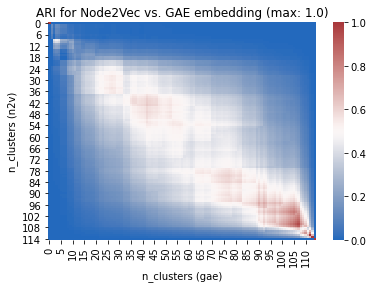

<IPython.core.display.Javascript object>

In [24]:
plot_cocluster_metric(
    ari_n2v_gae, "ARI for Node2Vec vs. GAE embedding", "gae", "n2v", vmin=0, vmax=1.0
)

In [25]:
ari_n2v_gex_gae = compare_dist_clustering(
    n2v_dist, gex_gae_dist, filter_nodes=orf_targets
)

Compute ARI: 100%|██████████| 115/115 [00:30<00:00,  3.71it/s]


<IPython.core.display.Javascript object>

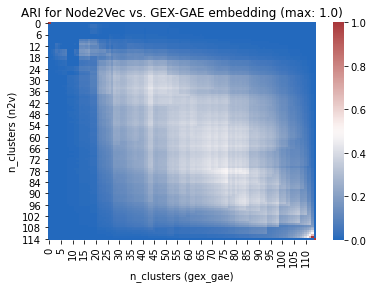

<IPython.core.display.Javascript object>

In [26]:
plot_cocluster_metric(
    ari_n2v_gex_gae,
    "ARI for Node2Vec vs. GEX-GAE embedding",
    "gex_gae",
    "n2v",
    vmin=0,
    vmax=1.0,
)

In [27]:
ari_n2v_pbulk_gex_gae = compare_dist_clustering(
    n2v_dist, pbulk_gex_gae_dist, filter_nodes=orf_targets
)

Compute ARI: 100%|██████████| 115/115 [00:30<00:00,  3.76it/s]


<IPython.core.display.Javascript object>

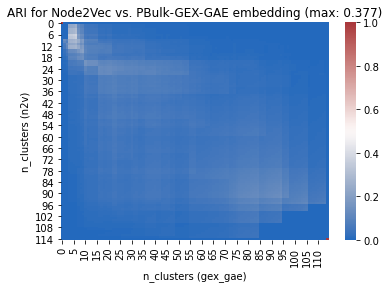

<IPython.core.display.Javascript object>

In [28]:
plot_cocluster_metric(
    ari_n2v_pbulk_gex_gae,
    "ARI for Node2Vec vs. PBulk-GEX-GAE embedding",
    "gex_gae",
    "n2v",
    vmin=0,
    vmax=1.0,
)

In [29]:
ari_n2v_spearman_gae = compare_dist_clustering(
    n2v_dist, spearman_gae_dist, filter_nodes=orf_targets
)

Compute ARI: 100%|██████████| 115/115 [00:30<00:00,  3.73it/s]


<IPython.core.display.Javascript object>

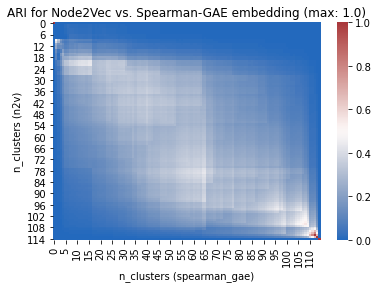

<IPython.core.display.Javascript object>

In [30]:
plot_cocluster_metric(
    ari_n2v_spearman_gae,
    "ARI for Node2Vec vs. Spearman-GAE embedding",
    "spearman_gae",
    "n2v",
    vmin=0,
    vmax=1.0,
)

In [31]:
ari_n2v_spearman_gex_gae = compare_dist_clustering(
    n2v_dist, spearman_gex_gae_dist, filter_nodes=orf_targets
)

Compute ARI: 100%|██████████| 115/115 [00:30<00:00,  3.71it/s]


<IPython.core.display.Javascript object>

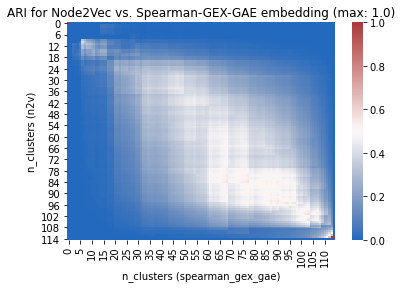

<IPython.core.display.Javascript object>

In [32]:
plot_cocluster_metric(
    ari_n2v_spearman_gex_gae,
    "ARI for Node2Vec vs. Spearman-GEX-GAE embedding",
    "spearman_gex_gae",
    "n2v",
    vmin=0,
    vmax=1.0,
)

In [33]:
ari_gae_gex_gae = compare_dist_clustering(
    gae_dist, gex_gae_dist, filter_nodes=orf_targets
)

Compute ARI: 100%|██████████| 115/115 [00:30<00:00,  3.73it/s]


<IPython.core.display.Javascript object>

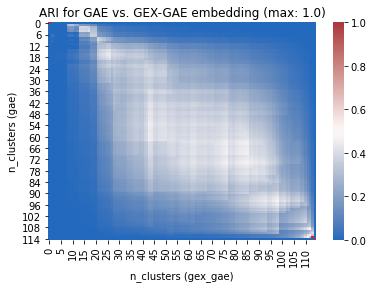

<IPython.core.display.Javascript object>

In [34]:
plot_cocluster_metric(
    ari_gae_gex_gae,
    "ARI for GAE vs. GEX-GAE embedding",
    "gex_gae",
    "gae",
    vmin=0,
    vmax=1.0,
)

In [35]:
ari_gae_pbulk_gex_gae = compare_dist_clustering(
    gae_dist, pbulk_gex_gae_dist, filter_nodes=orf_targets
)

Compute ARI: 100%|██████████| 115/115 [00:30<00:00,  3.75it/s]


<IPython.core.display.Javascript object>

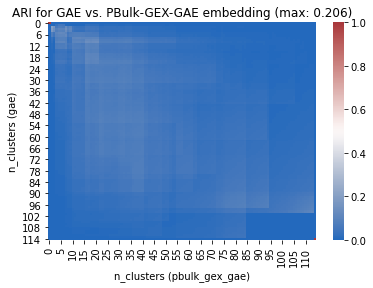

<IPython.core.display.Javascript object>

In [36]:
plot_cocluster_metric(
    ari_gae_pbulk_gex_gae,
    "ARI for GAE vs. PBulk-GEX-GAE embedding",
    "pbulk_gex_gae",
    "gae",
    vmin=0,
    vmax=1.0,
)

In [37]:
ari_gae_spearman_gae = compare_dist_clustering(
    gae_dist, spearman_gae_dist, filter_nodes=orf_targets
)

Compute ARI: 100%|██████████| 115/115 [00:30<00:00,  3.77it/s]


<IPython.core.display.Javascript object>

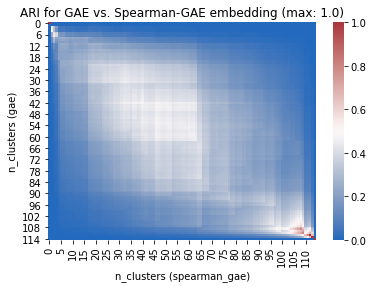

<IPython.core.display.Javascript object>

In [38]:
plot_cocluster_metric(
    ari_gae_spearman_gae,
    "ARI for GAE vs. Spearman-GAE embedding",
    "spearman_gae",
    "gae",
    vmin=0,
    vmax=1.0,
)

In [39]:
ari_gae_spearman_gex_gae = compare_dist_clustering(
    gae_dist, spearman_gex_gae_dist, filter_nodes=orf_targets
)

Compute ARI: 100%|██████████| 115/115 [00:30<00:00,  3.72it/s]


<IPython.core.display.Javascript object>

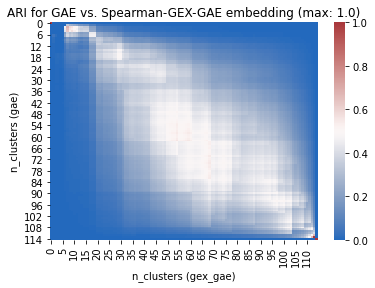

<IPython.core.display.Javascript object>

In [40]:
plot_cocluster_metric(
    ari_gae_spearman_gex_gae,
    "ARI for GAE vs. Spearman-GEX-GAE embedding",
    "gex_gae",
    "gae",
    vmin=0,
    vmax=1.0,
)

In [41]:
ari_spearman_gae_spearman_gex_gae = compare_dist_clustering(
    spearman_gae_dist, spearman_gex_gae_dist, filter_nodes=orf_targets
)

Compute ARI: 100%|██████████| 115/115 [00:30<00:00,  3.74it/s]


<IPython.core.display.Javascript object>

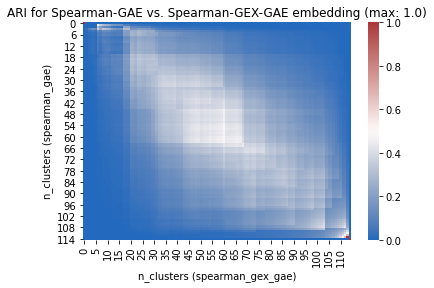

<IPython.core.display.Javascript object>

In [42]:
plot_cocluster_metric(
    ari_spearman_gae_spearman_gex_gae,
    "ARI for Spearman-GAE vs. Spearman-GEX-GAE embedding",
    "spearman_gex_gae",
    "spearman_gae",
    vmin=0,
    vmax=1.0,
)

In [43]:
ari_gex_gae_pbulk_gex_gae = compare_dist_clustering(
    gex_gae_dist, pbulk_gex_gae_dist, filter_nodes=orf_targets
)

Compute ARI: 100%|██████████| 115/115 [00:30<00:00,  3.77it/s]


<IPython.core.display.Javascript object>

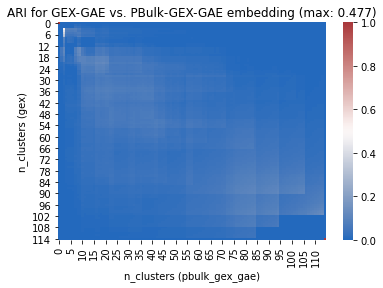

<IPython.core.display.Javascript object>

In [44]:
plot_cocluster_metric(
    ari_gex_gae_pbulk_gex_gae,
    "ARI for GEX-GAE vs. PBulk-GEX-GAE embedding",
    "pbulk_gex_gae",
    "gex",
    vmin=0,
    vmax=1.0,
)

The previous analysis shows that the solutions that do not make use of the gene-expression directly but only via the correlation as an paramter for the edge weights lead to a relatively large overlap of the clusters. The adjusted RandIndex comparing the Node2Vec solution to the one of the GAE with and without the Spearman correlation as input for the edge weights is 0.4-0.5 for a number of clusters between 2-10 and increases to 0.666-0.769 for a larger number of clusters.

Additionally, we find that the embeddings of the GAE with and without the Spearman-r based edge weights yield highly comparable embeddings as the adjusted RandIndex is up to 0.806 for 2-10 clusters respectively up to 0.909 for a larger number of clusters.

Interestingly, the embeddings derived from the GAE using the transformed single-cell gene expression values as node features are less comparable to the other solutions in general. However, when additionally using the Spearman-correlation as edge weights the clustering of the embeddings are again more similar to those obtained from the other embeddings.

In summary, while the embedding derived from the GAE using only the gene expression data as node features seems to yield an embedding that is dominated by the expression profiles and less by the graph structure, the remaining embeddings are potential candidates for the final embedding of the interactome. At this point one might favor the embedding obtained from the GAE using the Spearman r-based edge weights as the prefered embedding as it seems to sufficiently well capture the graph structure while also incorporating more U2OS-specific information in form of the correlation schemes.

### 2.2. Comparison of the clustering with the CMAP data set

We will now additionally assess the co-clustering of the nodes in the interactome embeddings with a clustering obtained from a set of gene signatures of the CMAP data set that describes the differential expression in U2OS cells in the different OE conditions compared to a negative control. We will cluster the signatures using hierarchical clustering with average linkage and the cosine distance. The intuition for using the cosine distance is that we expect the OE of genes that are close by in the regulatory space lead to similar changes in the functional profiles but potentially at different magnitudes depending on whether or not e.g. one gene is upstream of another.

#### 2.2.a. TSNE visualization of the data.

Before we proceed we will however visualize the data using a TSNE plot where we use the cosine distance to build the nearest neighbor graph.

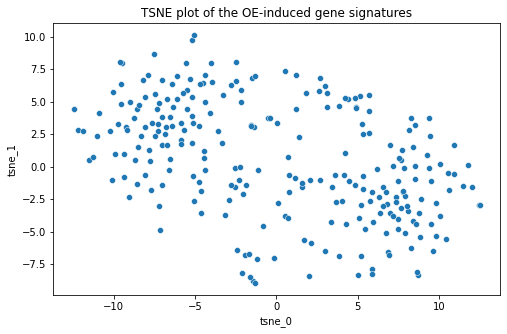

<IPython.core.display.Javascript object>

In [45]:
fig, ax = plot_data(
    cmap_data.iloc[:, :-1],
    metric="cosine",
    perplexity=30,
    figsize=[8, 5],
    normalize=True,
    reduction="tsne",
)
ax.set_title("TSNE plot of the OE-induced gene signatures")
plt.show()

The plot shows that there is quite some structure in the gene signatures with at least two clusters becoming apparent.

#### 2.1.b. Cosine simularity clustering.

Next, we will perform agglomerative clustering of the data based on their cosine similarities. However, we will focus only on that part of the data that describes OE epression for which we also have imaging data available.

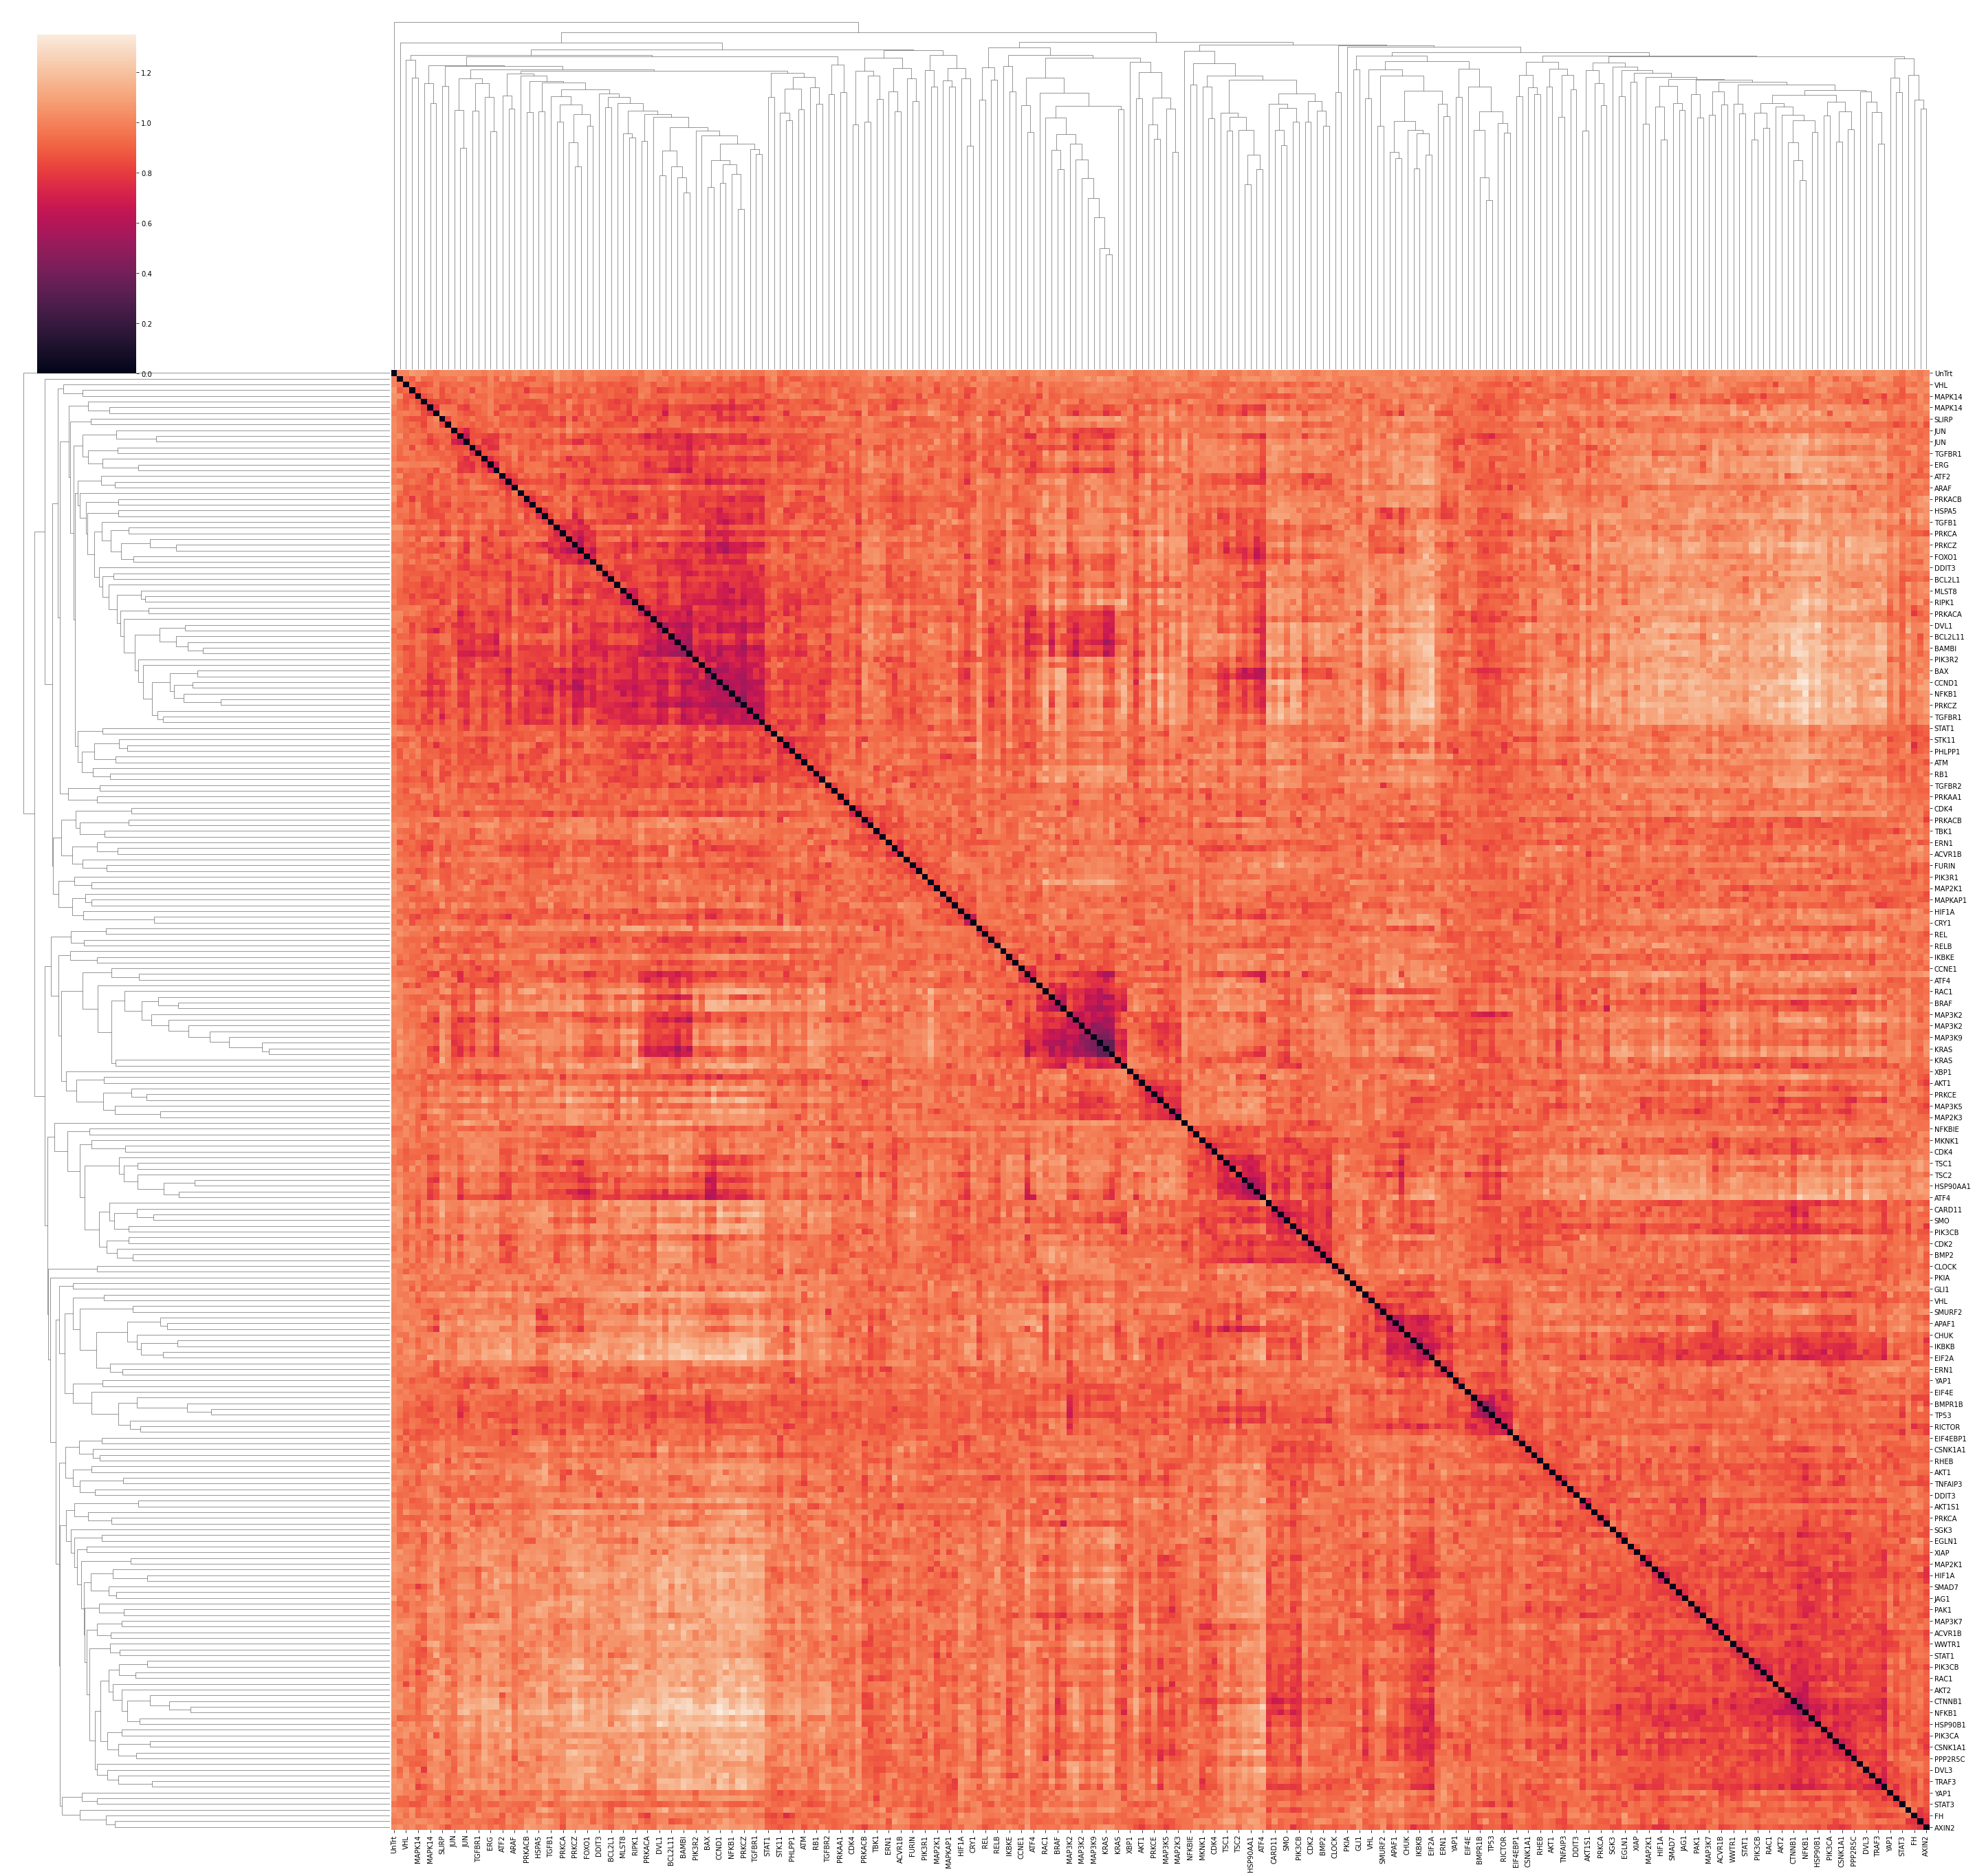

<IPython.core.display.Javascript object>

In [46]:
cmap_dist = pd.DataFrame(
    squareform(pdist(cmap_data.iloc[:, :-1], metric="cosine")),
    columns=list(cmap_data.iloc[:, -1]),
    index=list(cmap_data.iloc[:, -1]),
)
linkage = hc.linkage(sp.distance.squareform(cmap_dist), method="average")
ax = sns.clustermap(
    cmap_dist, row_linkage=linkage, col_linkage=linkage, figsize=[40, 38]
)

The plotted heatmap shows the cosine distance between each individual gene signature and a hierarchical clustering of the respective using the euclidean distance and average linkage.

Interestingly, we see that e.g. OE condition that target different alleles of FOXO1 cluster together as expected. The clustering will be analyzed further later in comparison to the clustering obtained in the regulatory and structural space.

---

#### 2.2.b. Co-clustering of the GEX signatures and the interactome embeddings

In [47]:
ari_n2v_cmap = compare_dist_clustering(n2v_dist, cmap_dist, filter_nodes=orf_targets)

Compute ARI: 100%|██████████| 102/102 [00:23<00:00,  4.31it/s]


<IPython.core.display.Javascript object>

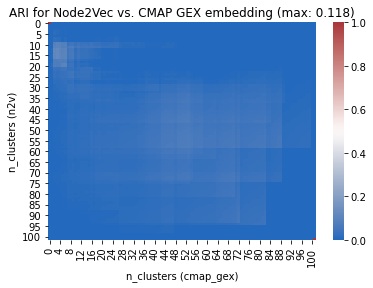

<IPython.core.display.Javascript object>

In [48]:
plot_cocluster_metric(
    ari_n2v_cmap,
    "ARI for Node2Vec vs. CMAP GEX embedding",
    "cmap_gex",
    "n2v",
    vmin=0,
    vmax=1.0,
)

In [49]:
ari_gae_cmap = compare_dist_clustering(gae_dist, cmap_dist, filter_nodes=orf_targets)

Compute ARI: 100%|██████████| 102/102 [00:23<00:00,  4.36it/s]


<IPython.core.display.Javascript object>

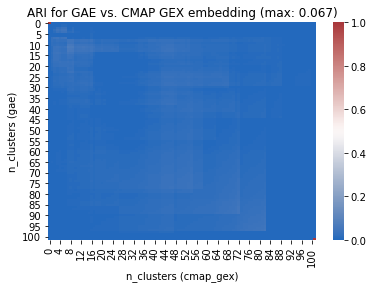

<IPython.core.display.Javascript object>

In [50]:
plot_cocluster_metric(
    ari_gae_cmap,
    "ARI for GAE vs. CMAP GEX embedding",
    "cmap_gex",
    "gae",
    vmin=0,
    vmax=1.0,
)

In [51]:
ari_gex_gae_cmap = compare_dist_clustering(
    gex_gae_dist, cmap_dist, filter_nodes=orf_targets
)

Compute ARI: 100%|██████████| 102/102 [00:23<00:00,  4.38it/s]


<IPython.core.display.Javascript object>

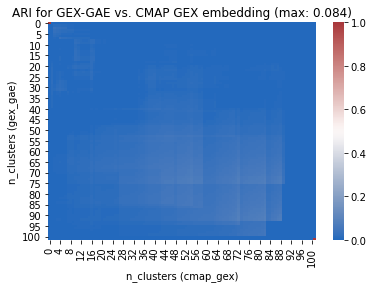

<IPython.core.display.Javascript object>

In [52]:
plot_cocluster_metric(
    ari_gex_gae_cmap,
    "ARI for GEX-GAE vs. CMAP GEX embedding",
    "cmap_gex",
    "gex_gae",
    vmin=0,
    vmax=1.0,
)

In [53]:
ari_spearman_gae_cmap = compare_dist_clustering(
    spearman_gae_dist, cmap_dist, filter_nodes=orf_targets
)

Compute ARI: 100%|██████████| 102/102 [00:23<00:00,  4.38it/s]


<IPython.core.display.Javascript object>

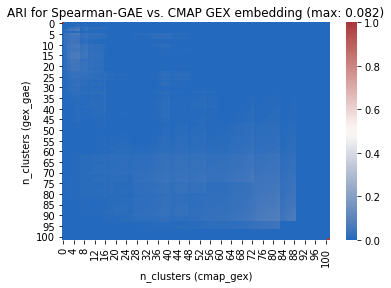

<IPython.core.display.Javascript object>

In [54]:
plot_cocluster_metric(
    ari_spearman_gae_cmap,
    "ARI for Spearman-GAE vs. CMAP GEX embedding",
    "cmap_gex",
    "gex_gae",
    vmin=0,
    vmax=1.0,
)

In [55]:
ari_spearman_gex_gae_cmap = compare_dist_clustering(
    spearman_gex_gae_dist, cmap_dist, filter_nodes=orf_targets
)

Compute ARI: 100%|██████████| 102/102 [00:22<00:00,  4.44it/s]


<IPython.core.display.Javascript object>

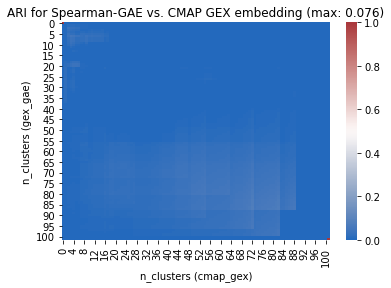

<IPython.core.display.Javascript object>

In [56]:
plot_cocluster_metric(
    ari_spearman_gex_gae_cmap,
    "ARI for Spearman-GAE vs. CMAP GEX embedding",
    "cmap_gex",
    "gex_gae",
    vmin=0,
    vmax=1.0,
)

We find that for all of the above solutions, there is no prominent co-clustering of the genes in the derived interactome embedding spaces and the gene signature space as the corresponding adjusted RandIndex is below 0.2 for all solutions. Interestingly, the highest value is obtained for the interactome embeddings computed using Node2Vec that is 0.187.

---

### 2.3. Comparison with the clustering of the image embeddings

Finally, we will cluster of the image embeddings using hierarchical clustering with average linkage and euclidean distance for the median of the embeddings for each of the covered specific ORF targets. We will then compare the cluster solutions as before with the ones from the different interactome embeddings and the GEX signatures from the CMAP data set.

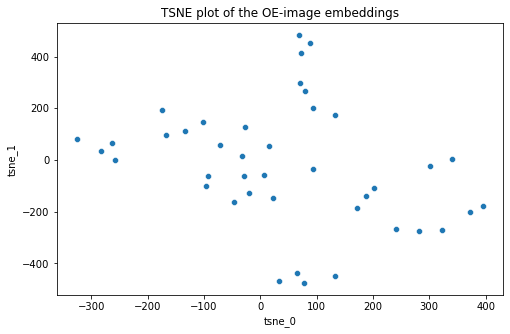

<IPython.core.display.Javascript object>

In [57]:
fig, ax = plot_data(
    img_embs,
    metric="euclidean",
    perplexity=4,
    figsize=[8, 5],
    normalize=True,
    reduction="tsne",
)
ax.set_title("TSNE plot of the OE-image embeddings")
plt.show()

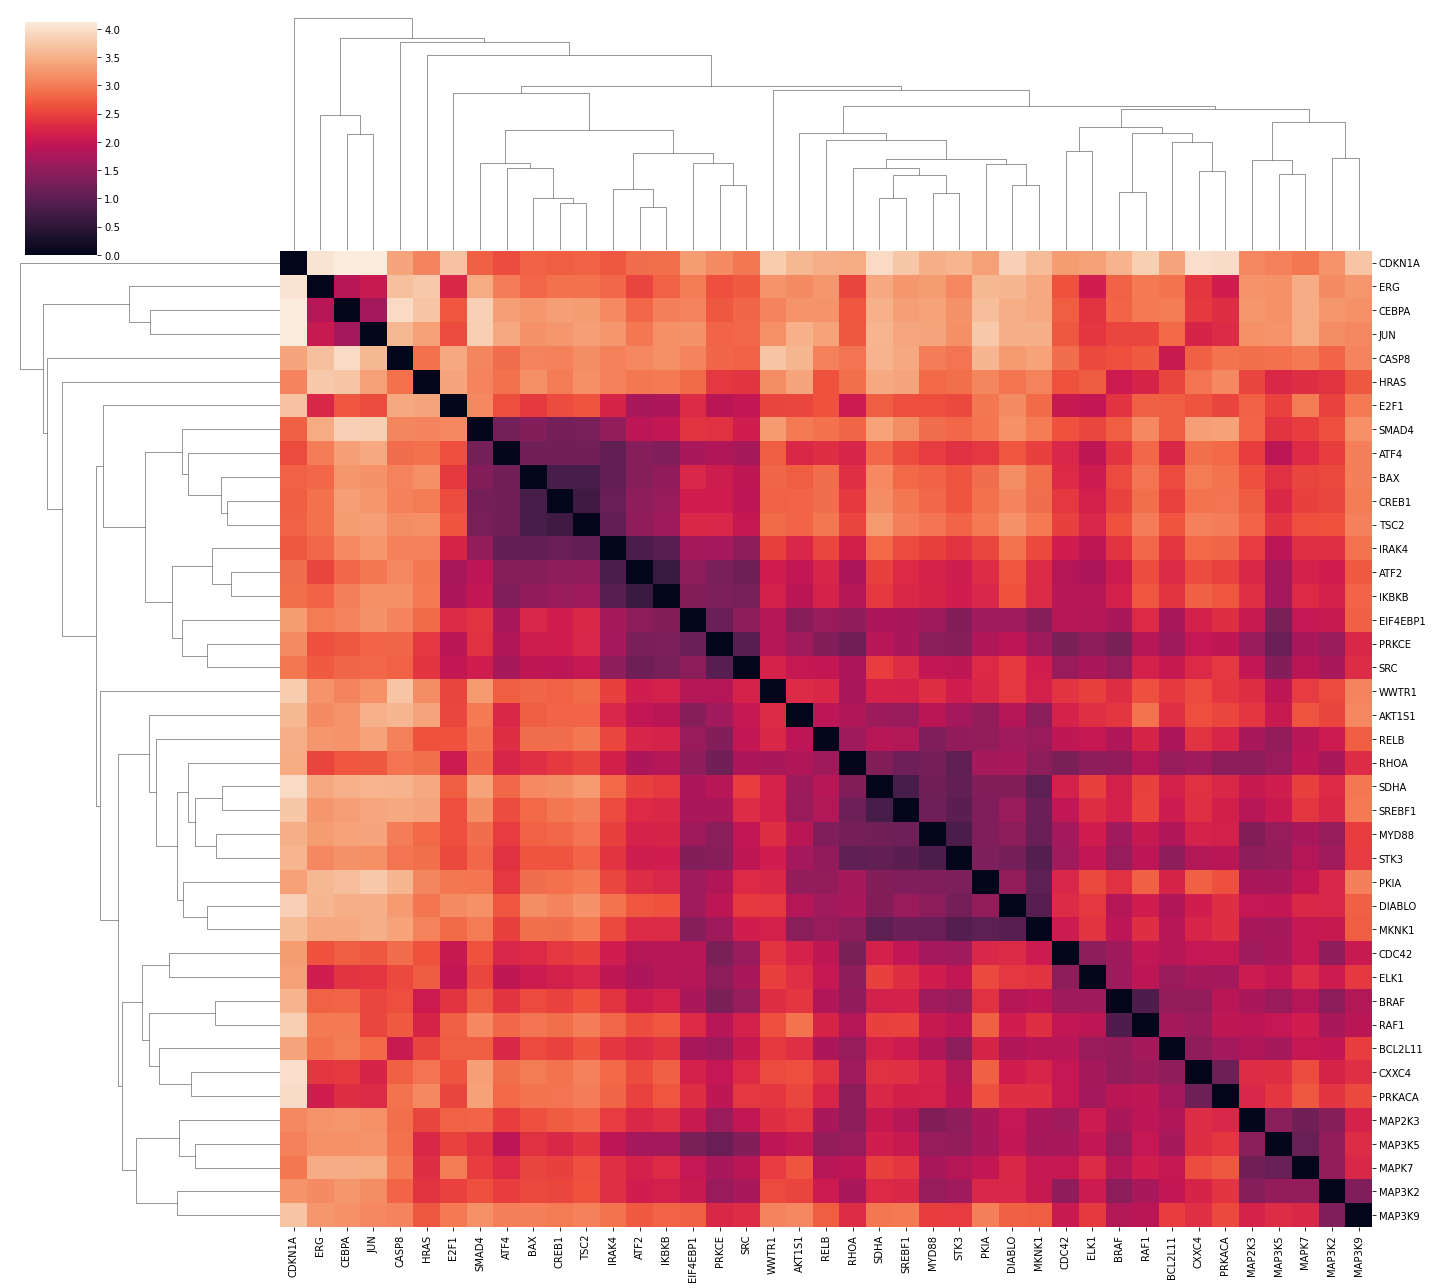

<IPython.core.display.Javascript object>

In [58]:
img_dist = pd.DataFrame(
    squareform(pdist(img_embs, metric="euclidean")),
    columns=list(img_embs.index),
    index=list(img_embs.index),
)
linkage = hc.linkage(sp.distance.squareform(img_dist), method="average")
ax = sns.clustermap(
    img_dist, row_linkage=linkage, col_linkage=linkage, figsize=[20, 18]
)

In [59]:
ari_img_cmap = compare_dist_clustering(
    img_dist, cmap_dist, linkage1="average", linkage2="average"
)

Compute ARI: 100%|██████████| 35/35 [00:02<00:00, 16.16it/s]


<IPython.core.display.Javascript object>

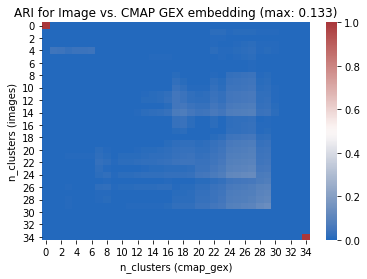

<IPython.core.display.Javascript object>

In [60]:
plot_cocluster_metric(
    ari_img_cmap,
    "ARI for Image vs. CMAP GEX embedding",
    "cmap_gex",
    "images",
    vmin=0,
    vmax=1.0,
)

In [61]:
ari_img_n2v = compare_dist_clustering(
    img_dist, n2v_dist, linkage1="average", linkage2="average"
)

Compute ARI: 100%|██████████| 40/40 [00:02<00:00, 13.82it/s]


<IPython.core.display.Javascript object>

In [62]:
ami_img_n2v = compare_dist_clustering(
    img_dist, n2v_dist, linkage1="average", linkage2="average", metric="ami"
)

Compute ARI: 100%|██████████| 40/40 [00:05<00:00,  7.80it/s]


<IPython.core.display.Javascript object>

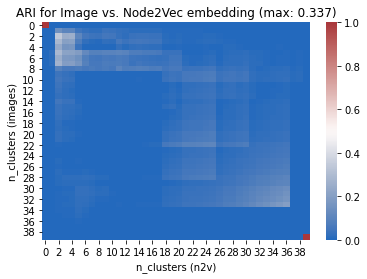

<IPython.core.display.Javascript object>

In [63]:
plot_cocluster_metric(
    ari_img_n2v,
    "ARI for Image vs. Node2Vec embedding",
    "n2v",
    "images",
    vmin=0,
    vmax=1,
)

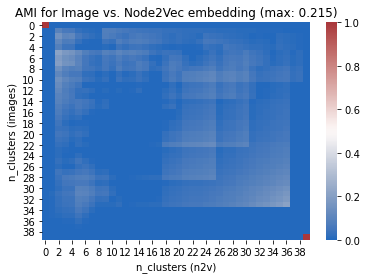

<IPython.core.display.Javascript object>

In [64]:
plot_cocluster_metric(
    ami_img_n2v,
    "AMI for Image vs. Node2Vec embedding",
    "n2v",
    "images",
    vmin=0,
    vmax=1,
)

In [65]:
ari_img_gae = compare_dist_clustering(img_dist, gae_dist)

Compute ARI: 100%|██████████| 40/40 [00:02<00:00, 13.75it/s]


<IPython.core.display.Javascript object>

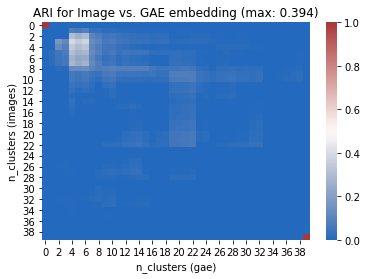

<IPython.core.display.Javascript object>

In [66]:
plot_cocluster_metric(
    ari_img_gae,
    "ARI for Image vs. GAE embedding",
    "gae",
    "images",
    vmin=0,
    vmax=1.0,
)

In [67]:
ari_img_spearman_gae = compare_dist_clustering(img_dist, spearman_gae_dist)

Compute ARI: 100%|██████████| 40/40 [00:02<00:00, 13.71it/s]


<IPython.core.display.Javascript object>

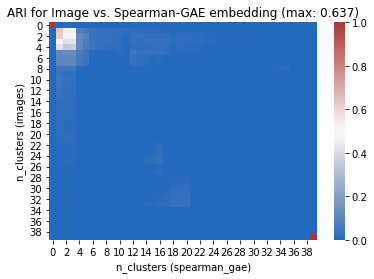

<IPython.core.display.Javascript object>

In [68]:
plot_cocluster_metric(
    ari_img_spearman_gae,
    "ARI for Image vs. Spearman-GAE embedding",
    "spearman_gae",
    "images",
    vmin=0,
    vmax=1.0,
)

In [69]:
ari_img_gex_gae = compare_dist_clustering(img_dist, gex_gae_dist)

Compute ARI: 100%|██████████| 40/40 [00:02<00:00, 14.28it/s]


<IPython.core.display.Javascript object>

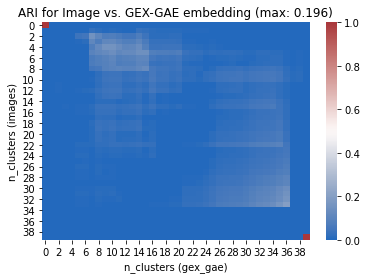

<IPython.core.display.Javascript object>

In [70]:
plot_cocluster_metric(
    ari_img_gex_gae,
    "ARI for Image vs. GEX-GAE embedding",
    "gex_gae",
    "images",
    vmin=0,
    vmax=1.0,
)

In [71]:
ari_img_spearman_gex_gae = compare_dist_clustering(img_dist, spearman_gex_gae_dist)

Compute ARI: 100%|██████████| 40/40 [00:02<00:00, 13.68it/s]


<IPython.core.display.Javascript object>

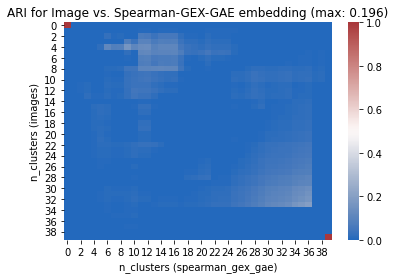

<IPython.core.display.Javascript object>

In [72]:
plot_cocluster_metric(
    ari_img_spearman_gex_gae,
    "ARI for Image vs. Spearman-GEX-GAE embedding",
    "spearman_gex_gae",
    "images",
    vmin=0,
    vmax=1.0,
)